In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

C:\Users\talkt\AppData\Local\Temp\ipykernel_16884\182252112.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Reading Data

In [116]:
raw_data = pd.read_csv("data_raw.csv")
raw_data

,Account,ATMID,caldate,Dispense,DT,MaxCapacity,CountTotalTxn
0,ABC,SPCN02020,01-01-2021,564500,0,2640000,157
1,ABC,TPCN10269,01-01-2021,509000,9,3520000,92
2,ABC,APCN00816,01-01-2021,64800,0,2640000,36
3,PQR,S1CN1142,01-01-2021,834500,0,3520000,101
4,PQR,S1CN2022,01-01-2021,825700,0,2860000,364
...,...,...,...,...,...,...,...
14588,XYZ,T1BH000274012,22-02-2023,381700,0,2860000,126
14589,XYZ,T1NH000575414,22-02-2023,452500,565,3520000,134
14590,PQR,S1CN2011,22-02-2023,0,0,3520000,0
14591,XYZ,T1BH007252090,22-02-2023,137600,0,3520000,73


In [117]:
df = raw_data

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14593 entries, 0 to 14592
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Account        14593 non-null  object
 1   ATMID          14593 non-null  object
 2   caldate        14593 non-null  object
 3   Dispense       14593 non-null  int64 
 4   DT             14593 non-null  int64 
 5   MaxCapacity    14593 non-null  int64 
 6   CountTotalTxn  14593 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 798.2+ KB


In [119]:
df.columns

Index(['Account', 'ATMID', 'caldate', 'Dispense', 'DT', 'MaxCapacity',
       'CountTotalTxn'],
      dtype='object')

In [120]:
# Convert 'date_column' from object type to datetime type
df['date'] = pd.to_datetime(df['caldate'],format='%d-%m-%Y')

In [121]:
# One-Hot Encoding for the bank Column
df1 = df[['Account','ATMID','date','MaxCapacity','CountTotalTxn','Dispense']]
df1

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense
0,ABC,SPCN02020,2021-01-01,2640000,157,564500
1,ABC,TPCN10269,2021-01-01,3520000,92,509000
2,ABC,APCN00816,2021-01-01,2640000,36,64800
3,PQR,S1CN1142,2021-01-01,3520000,101,834500
4,PQR,S1CN2022,2021-01-01,2860000,364,825700
...,...,...,...,...,...,...
14588,XYZ,T1BH000274012,2023-02-22,2860000,126,381700
14589,XYZ,T1NH000575414,2023-02-22,3520000,134,452500
14590,PQR,S1CN2011,2023-02-22,3520000,0,0
14591,XYZ,T1BH007252090,2023-02-22,3520000,73,137600


## Analyzing Data

In [122]:
# Count rows where the value of dispense is less than 10
count_less_than_10 = df1[df1['Dispense'] < 10].shape[0]
count_less_than_10

1003

In [123]:
# Drop rows where the value of dispense is less than 10
df1 = df1[df1['Dispense'] >= 10]

In [124]:
# Find counts of unique values in the column
value_counts = df['MaxCapacity'].value_counts()
value_counts

MaxCapacity
3520000    9281
2860000    2180
2640000    1566
3740000     783
2420000     783
Name: count, dtype: int64

In [179]:
def visualize_numerical_variables(dataframe, numerical_vars):
    for var in numerical_vars:
        # Create a new figure with subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Plot Histogram
        sns.histplot(dataframe[var], kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {var}')
        axes[0].ticklabel_format(style='plain', axis='both')

        # Plot Box Plot
        sns.boxplot(x=dataframe[var], ax=axes[1])
        axes[1].set_title(f'Box Plot of {var}')

        # Adjust layout
        plt.tight_layout()

        # Show the plots
        plt.show()

In [180]:
numerical_vars = ['CountTotalTxn','Dispense']

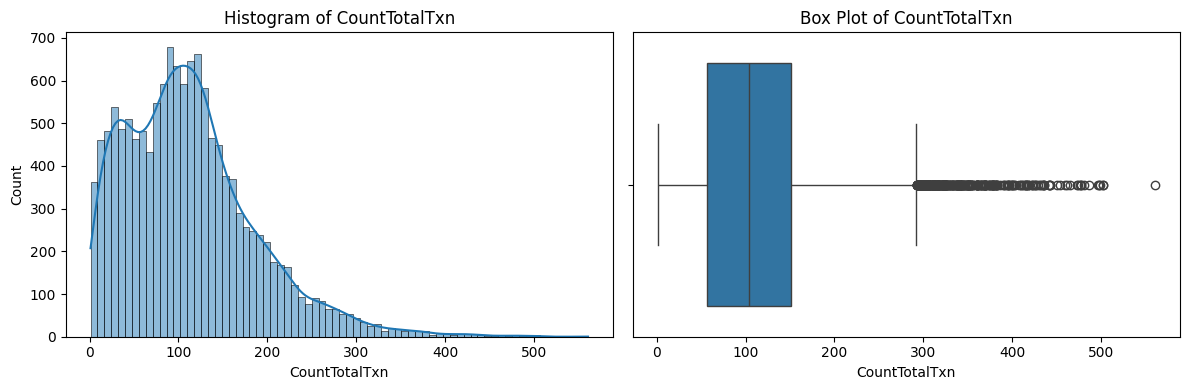

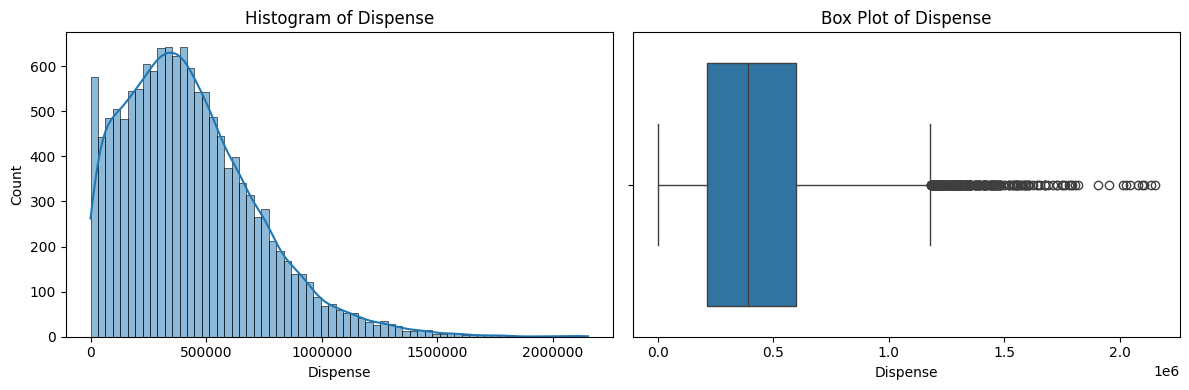

In [181]:
visualize_numerical_variables(df1, numerical_vars)

In [182]:
def visualize_numerical_variables(dataframe, numerical_var, categorical_var):
    # Create a new figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Histogram grouped by categories in categorical variable
    sns.histplot(data=dataframe, x=numerical_var, hue=categorical_var, kde=True, ax=axes[0], multiple='stack')
    axes[0].set_title(f'Histogram of {numerical_var} by {categorical_var}')
    axes[0].ticklabel_format(style='plain', axis='both')

    # Plot Box Plot
    sns.boxplot(data=dataframe, x=categorical_var, y=numerical_var, ax=axes[1])
    axes[1].set_title(f'Box Plot of {numerical_var} by {categorical_var}')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 13590 and the vector passed to `x` has length 2.

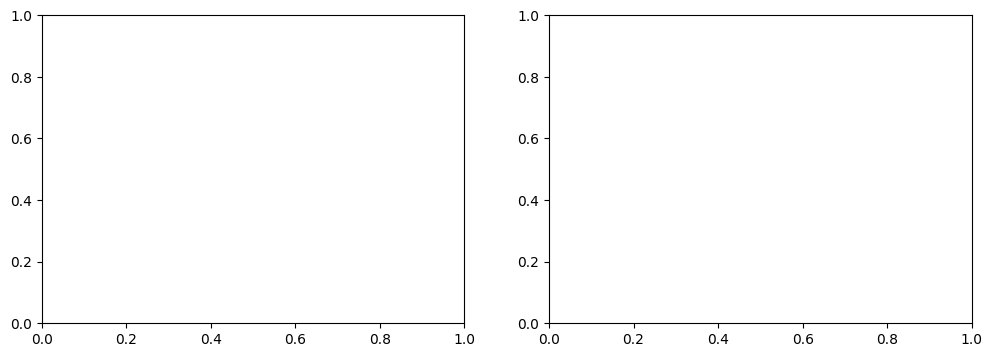

In [183]:
visualize_numerical_variables(df1, numerical_vars, categorical_var='Account')

In [157]:
def percentile_values(data):

    # Define percentiles
    percentiles = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]  # You can add any other percentiles as needed

    # Calculate values at each percentile
    percentile_values = np.percentile(data, percentiles)

    # Print the values at each percentile
    for p, value in zip(percentiles, percentile_values):
        print(f'{p}th percentile: {value}')

In [158]:
percentile_values(df1['CountTotalTxn'])

1th percentile: 4.0
10th percentile: 25.0
20th percentile: 46.0
30th percentile: 68.0
40th percentile: 87.0
50th percentile: 104.0
60th percentile: 121.0
70th percentile: 139.0
80th percentile: 166.0
90th percentile: 210.0
99th percentile: 344.0


In [160]:
percentile_values(df1['Dispense'])

1th percentile: 5000.0
10th percentile: 86500.0
20th percentile: 173000.0
30th percentile: 251500.0
40th percentile: 322000.0
50th percentile: 390700.0
60th percentile: 463500.0
70th percentile: 547000.0
80th percentile: 654540.0000000001
90th percentile: 818000.0
99th percentile: 1319704.0000000037


In [85]:
df1['day_of_week_number'] = df1['date'].dt.dayofweek
df1['quarter'] = df1['date'].dt.quarter
df1['month'] = df1['date'].dt.month
df1['year'] = df1['date'].dt.year
df1['day_of_year'] = df1['date'].dt.dayofyear
df1['week'] = df1['date'].dt.isocalendar().week

C:\Users\talkt\AppData\Local\Temp\ipykernel_16884\1215847979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['day_of_week_number'] = df1['date'].dt.dayofweek
C:\Users\talkt\AppData\Local\Temp\ipykernel_16884\1215847979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['quarter'] = df1['date'].dt.quarter
C:\Users\talkt\AppData\Local\Temp\ipykernel_16884\1215847979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [86]:
df1

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense,day_of_week_number,quarter,month,year,day_of_year,week
0,ABC,SPCN02020,2021-01-01,2640000,157,564500,4,1,1,2021,1,53
1,ABC,TPCN10269,2021-01-01,3520000,92,509000,4,1,1,2021,1,53
2,ABC,APCN00816,2021-01-01,2640000,36,64800,4,1,1,2021,1,53
3,PQR,S1CN1142,2021-01-01,3520000,101,834500,4,1,1,2021,1,53
4,PQR,S1CN2022,2021-01-01,2860000,364,825700,4,1,1,2021,1,53
...,...,...,...,...,...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,3520000,87,208000,2,1,2,2023,53,8
14588,XYZ,T1BH000274012,2023-02-22,2860000,126,381700,2,1,2,2023,53,8
14589,XYZ,T1NH000575414,2023-02-22,3520000,134,452500,2,1,2,2023,53,8
14591,XYZ,T1BH007252090,2023-02-22,3520000,73,137600,2,1,2,2023,53,8


In [87]:
# One-Hot Encoding for the bank Column
one_hot_ecoded_banks = pd.get_dummies(df1['Account'], prefix='bank')
one_hot_ecoded_atm = pd.get_dummies(df1['ATMID'], prefix='ATM')

In [89]:
# Concatenating the encoded DataFrame with the main DataFrame
df2 = pd.concat([df1, one_hot_ecoded_banks, one_hot_ecoded_atm], axis=1)

In [90]:
df2

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense,day_of_week_number,quarter,month,year,...,ATM_SPCND067,ATM_SPCNG376,ATM_T1BH000003039,ATM_T1BH000011116,ATM_T1BH000274012,ATM_T1BH000603091,ATM_T1BH007252090,ATM_T1NH000575414,ATM_T1NY000166081,ATM_TPCN10269
0,ABC,SPCN02020,2021-01-01,2640000,157,564500,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
1,ABC,TPCN10269,2021-01-01,3520000,92,509000,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,True
2,ABC,APCN00816,2021-01-01,2640000,36,64800,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
3,PQR,S1CN1142,2021-01-01,3520000,101,834500,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
4,PQR,S1CN2022,2021-01-01,2860000,364,825700,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,3520000,87,208000,2,1,2,2023,...,False,False,False,False,False,True,False,False,False,False
14588,XYZ,T1BH000274012,2023-02-22,2860000,126,381700,2,1,2,2023,...,False,False,False,False,True,False,False,False,False,False
14589,XYZ,T1NH000575414,2023-02-22,3520000,134,452500,2,1,2,2023,...,False,False,False,False,False,False,False,True,False,False
14591,XYZ,T1BH007252090,2023-02-22,3520000,73,137600,2,1,2,2023,...,False,False,False,False,False,False,True,False,False,False


In [91]:
train = df2.loc[df2.date <= '2023-01-01']
test = df2.loc[df2.date > '2023-01-01']

In [92]:
df2.columns

Index(['Account', 'ATMID', 'date', 'MaxCapacity', 'CountTotalTxn', 'Dispense',
       'day_of_week_number', 'quarter', 'month', 'year', 'day_of_year', 'week',
       'bank_ABC', 'bank_PQR', 'bank_XYZ', 'ATM_APAN11109', 'ATM_APAN22403',
       'ATM_APAN23217', 'ATM_APAN35706', 'ATM_APCN00816', 'ATM_S1CN1142',
       'ATM_S1CN2011', 'ATM_S1CN2022', 'ATM_S1CN2820', 'ATM_S1CN3514',
       'ATM_SPCN02020', 'ATM_SPCND067', 'ATM_SPCNG376', 'ATM_T1BH000003039',
       'ATM_T1BH000011116', 'ATM_T1BH000274012', 'ATM_T1BH000603091',
       'ATM_T1BH007252090', 'ATM_T1NH000575414', 'ATM_T1NY000166081',
       'ATM_TPCN10269'],
      dtype='object')

In [102]:
features = ['day_of_week_number', 'quarter', 'month', 'year','day_of_year','week',
       'MaxCapacity',
       'bank_ABC', 'bank_PQR','bank_XYZ',
       'ATM_APAN11109','ATM_APAN22403', 'ATM_APAN23217', 'ATM_APAN35706', 'ATM_APCN00816',
       'ATM_S1CN1142', 'ATM_S1CN2011', 'ATM_S1CN2022', 'ATM_S1CN2820',
       'ATM_S1CN3514', 'ATM_SPCN02020', 'ATM_SPCND067', 'ATM_SPCNG376',
       'ATM_T1BH000003039', 'ATM_T1BH000011116', 'ATM_T1BH000274012',
       'ATM_T1BH000603091', 'ATM_T1BH007252090', 'ATM_T1NH000575414',
       'ATM_T1NY000166081', 'ATM_TPCN10269']
target = 'Dispense'

In [103]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [104]:
X_train

,day_of_week_number,quarter,month,year,day_of_year,week,MaxCapacity,bank_ABC,bank_PQR,bank_XYZ,...,ATM_SPCND067,ATM_SPCNG376,ATM_T1BH000003039,ATM_T1BH000011116,ATM_T1BH000274012,ATM_T1BH000603091,ATM_T1BH007252090,ATM_T1NH000575414,ATM_T1NY000166081,ATM_TPCN10269
0,4,1,1,2021,1,53,2640000,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1,1,2021,1,53,3520000,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,4,1,1,2021,1,53,2640000,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1,1,2021,1,53,3520000,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1,1,2021,1,53,2860000,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13496,6,1,1,2023,1,52,2860000,False,False,True,...,False,False,False,False,True,False,False,False,False,False
13497,6,1,1,2023,1,52,3520000,False,False,True,...,False,False,False,False,False,False,False,True,False,False
13498,6,1,1,2023,1,52,3520000,False,True,False,...,False,False,False,False,False,False,False,False,False,False
13499,6,1,1,2023,1,52,3520000,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [105]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12574, 31)
(12574,)
(1016, 31)
(1016,)


In [106]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train),
                                      (X_test, y_test)],
                                      verbose = True)

[0]	validation_0-rmse:295426.25164	validation_1-rmse:254502.60796
[1]	validation_0-rmse:294452.34963	validation_1-rmse:253813.24449
[2]	validation_0-rmse:293494.53577	validation_1-rmse:253139.45313
[3]	validation_0-rmse:292552.57638	validation_1-rmse:252480.97699
[4]	validation_0-rmse:291626.25505	validation_1-rmse:251837.55991
[5]	validation_0-rmse:290713.50926	validation_1-rmse:251200.42956
[6]	validation_0-rmse:289843.59117	validation_1-rmse:250586.87605
[7]	validation_0-rmse:288986.69596	validation_1-rmse:249970.22196
[8]	validation_0-rmse:288144.23163	validation_1-rmse:249369.24821
[9]	validation_0-rmse:287316.99387	validation_1-rmse:248785.74014
[10]	validation_0-rmse:286502.53334	validation_1-rmse:248226.31785
[11]	validation_0-rmse:285700.41748	validation_1-rmse:247707.59070
[12]	validation_0-rmse:284911.89523	validation_1-rmse:247178.37018
[13]	validation_0-rmse:284136.80395	validation_1-rmse:246663.19447
[14]	validation_0-rmse:283374.87117	validation_1-rmse:246188.89747
[15]	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [107]:
pd.DataFrame(data=reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values(by=['importance'],ascending=False)

,importance
ATM_APCN00816,0.133803
ATM_APAN35706,0.133322
ATM_S1CN2011,0.085795
ATM_TPCN10269,0.066126
ATM_S1CN2022,0.065179
ATM_S1CN1142,0.064062
ATM_T1NY000166081,0.058696
ATM_SPCND067,0.047248
ATM_T1BH000274012,0.039660
ATM_T1BH000603091,0.037220


In [108]:
test['prediction']=reg.predict(X_test)

C:\Users\talkt\AppData\Local\Temp\ipykernel_16884\716901839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=reg.predict(X_test)


In [109]:
test.head()

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense,day_of_week_number,quarter,month,year,...,ATM_SPCNG376,ATM_T1BH000003039,ATM_T1BH000011116,ATM_T1BH000274012,ATM_T1BH000603091,ATM_T1BH007252090,ATM_T1NH000575414,ATM_T1NY000166081,ATM_TPCN10269,prediction
13501,ABC,SPCN02020,2023-01-02,2640000,62,259000,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,434340.46875
13502,ABC,TPCN10269,2023-01-02,3520000,126,926500,0,1,1,2023,...,False,False,False,False,False,False,False,False,True,595365.62500
13503,ABC,APCN00816,2023-01-02,2640000,29,197000,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,174383.81250
13505,PQR,S1CN2022,2023-01-02,2860000,245,728600,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,903967.68750
13506,PQR,SPCND067,2023-01-02,3520000,168,972000,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,568139.12500


In [110]:
test.shape

(1016, 37)

In [111]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['Dispense'], test['prediction'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 217559.5474935268


In [115]:
test['Dispense'].mean()

411121.55511811026